Starting HDVAE training with 3 hierarchical layers...
Epoch [1/5], Step [100/469], Loss: 24582.7578
Epoch [1/5], Step [200/469], Loss: 24010.3477
Epoch [1/5], Step [300/469], Loss: 20176.5664
Epoch [1/5], Step [400/469], Loss: 19161.7559
Epoch [1/5] completed. Avg Loss: 179.5656, PSNR: 15.95, SSIM: 0.5972
Epoch [2/5], Step [100/469], Loss: 17145.3613
Epoch [2/5], Step [200/469], Loss: 16610.6699
Epoch [2/5], Step [300/469], Loss: 15953.0205
Epoch [2/5], Step [400/469], Loss: 15979.1660
Epoch [2/5] completed. Avg Loss: 130.9669, PSNR: 17.78, SSIM: 0.7205
Epoch [3/5], Step [100/469], Loss: 15569.8340
Epoch [3/5], Step [200/469], Loss: 16193.9102
Epoch [3/5], Step [300/469], Loss: 14969.3887
Epoch [3/5], Step [400/469], Loss: 15450.3730
Epoch [3/5] completed. Avg Loss: 122.0361, PSNR: 18.32, SSIM: 0.7392
Epoch [4/5], Step [100/469], Loss: 15344.4961
Epoch [4/5], Step [200/469], Loss: 14709.4746
Epoch [4/5], Step [300/469], Loss: 14938.6016
Epoch [4/5], Step [400/469], Loss: 14891.7598
Epo

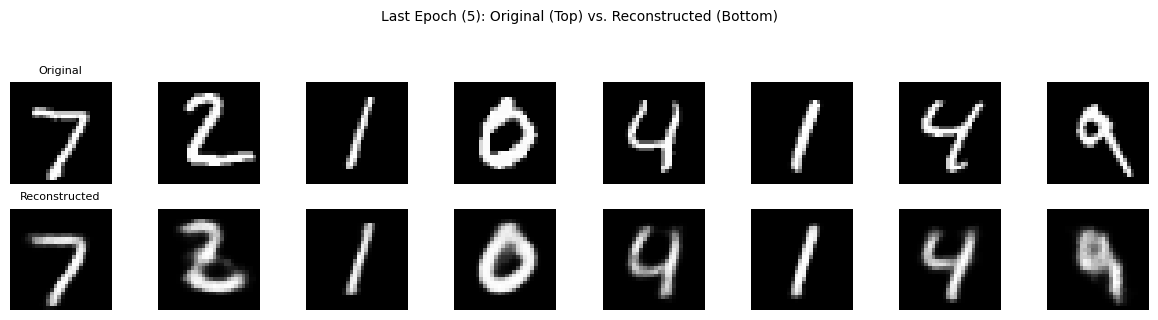

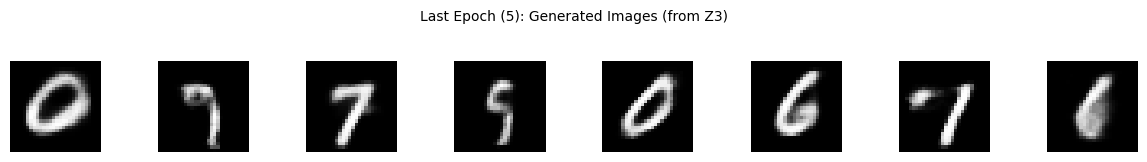

All display operations finished.


In [2]:
# V2 ==> 3-layer of Hierarchy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
image_size = 784
z1_dim = 64
z2_dim = 32
z3_dim = 16 # NEW: Dimensionality of the third latent variable
num_epochs = 5
batch_size = 128
learning_rate = 1e-3

# Create directories
os.makedirs('./sampled_images_hdvae', exist_ok=True)
os.makedirs('./plots_hdvae', exist_ok=True)

# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader_fixed_batch = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)
fixed_test_images, _ = next(iter(test_loader_fixed_batch))
fixed_test_images = fixed_test_images.to(device)


# HDVAE Model - 3 Hierarchical Latent Layers (z1, z2, z3)
class HDVAE(nn.Module):
    def __init__(self, image_size, z1_dim, z2_dim, z3_dim): # Added z3_dim
        super(HDVAE, self).__init__()
        self.image_size = image_size
        self.z1_dim = z1_dim
        self.z2_dim = z2_dim
        self.z3_dim = z3_dim # Stored z3_dim

        # Encoder X -> Z1 (Kept current deeper structure)
        self.encoder_x_to_z1 = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.fc_mu1 = nn.Linear(128, z1_dim)
        self.fc_logvar1 = nn.Linear(128, z1_dim)

        # Encoder Z1 -> Z2 (Kept current deeper structure)
        self.encoder_z1_to_z2 = nn.Sequential(
            nn.Linear(z1_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.fc_mu2 = nn.Linear(64, z2_dim)
        self.fc_logvar2 = nn.Linear(64, z2_dim)

        # NEW: Encoder Z2 -> Z3
        self.encoder_z2_to_z3 = nn.Sequential(
            nn.Linear(z2_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.fc_mu3 = nn.Linear(64, z3_dim)
        self.fc_logvar3 = nn.Linear(64, z3_dim)

        # NEW: Decoder Z3 -> Z2 (Prior for Z2)
        self.decoder_z3_to_z2_params = nn.Sequential(
            nn.Linear(z3_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )
        self.fc_prior_mu2 = nn.Linear(128, z2_dim)
        self.fc_prior_logvar2 = nn.Linear(128, z2_dim)

        # Decoder Z2 -> Z1 (Prior for Z1 - Kept current deeper structure)
        self.decoder_z2_to_z1_params = nn.Sequential(
            nn.Linear(z2_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )
        self.fc_prior_mu1 = nn.Linear(128, z1_dim)
        self.fc_prior_logvar1 = nn.Linear(128, z1_dim)

        # Decoder Z1 -> X (Kept current deeper structure)
        self.decoder_z1_to_x = nn.Sequential(
            nn.Linear(z1_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, image_size),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        # x -> z1
        h1 = self.encoder_x_to_z1(x.view(-1, self.image_size))
        mu1, log_var1 = self.fc_mu1(h1), self.fc_logvar1(h1)
        z1 = self.reparameterize(mu1, log_var1)

        # z1 -> z2
        h2 = self.encoder_z1_to_z2(z1)
        mu2, log_var2 = self.fc_mu2(h2), self.fc_logvar2(h2)
        z2 = self.reparameterize(mu2, log_var2)

        # NEW: z2 -> z3
        h3 = self.encoder_z2_to_z3(z2)
        mu3, log_var3 = self.fc_mu3(h3), self.fc_logvar3(h3)
        z3 = self.reparameterize(mu3, log_var3)

        return (mu1, log_var1, z1), (mu2, log_var2, z2), (mu3, log_var3, z3) # Return z3 related params

    def decode(self, z1, z2, z3): # Added z3
        x_reconst = self.decoder_z1_to_x(z1)

        # Prior for z1 from z2
        h_prior_z1 = self.decoder_z2_to_z1_params(z2)
        mu_prior_1 = self.fc_prior_mu1(h_prior_z1)
        log_var_prior_1 = self.fc_prior_logvar1(h_prior_z1)

        # NEW: Prior for z2 from z3
        h_prior_z2 = self.decoder_z3_to_z2_params(z3)
        mu_prior_2 = self.fc_prior_mu2(h_prior_z2)
        log_var_prior_2 = self.fc_prior_logvar2(h_prior_z2)

        return x_reconst, (mu_prior_1, log_var_prior_1), (mu_prior_2, log_var_prior_2) # Return z2 prior params

    def forward(self, x):
        (mu1, log_var1, z1), (mu2, log_var2, z2), (mu3, log_var3, z3) = self.encode(x) # Unpack z3
        x_reconst, (mu_prior_1, log_var_prior_1), (mu_prior_2, log_var_prior_2) = self.decode(z1, z2, z3) # Pass z3

        # Return all required for loss calculation
        return x_reconst, mu1, log_var1, z1, mu2, log_var2, z2, mu3, log_var3, z3, \
               mu_prior_1, log_var_prior_1, mu_prior_2, log_var_prior_2

# Instantiate the model with the new z3_dim
model = HDVAE(image_size, z1_dim, z2_dim, z3_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# print(model) # Print model summary for inspection


# Loss Function for 3 Hierarchical Latent Layers
def loss_function_hdvae(recon_x, x,
                        mu1, log_var1,
                        mu2, log_var2,
                        mu3, log_var3, # Added mu3, log_var3
                        mu_prior_1, log_var_prior_1,
                        mu_prior_2, log_var_prior_2): # Added mu_prior_2, log_var_prior_2

    BCE = F.binary_cross_entropy(recon_x, x.view(-1, image_size), reduction='sum')

    # KLD for z3: relative to standard normal
    KLD_z3 = -0.5 * torch.sum(1 + log_var3 - mu3.pow(2) - log_var3.exp())

    # KLD for z2: relative to prior from z3
    KLD_z2 = 0.5 * torch.sum(
        torch.exp(log_var2 - log_var_prior_2) +
        ((mu_prior_2 - mu2)**2) * torch.exp(-log_var_prior_2) - 1 +
        (log_var_prior_2 - log_var2)
    )

    # KLD for z1: relative to prior from z2
    KLD_z1 = 0.5 * torch.sum(
        torch.exp(log_var1 - log_var_prior_1) +
        ((mu_prior_1 - mu1)**2) * torch.exp(-log_var_prior_1) - 1 +
        (log_var_prior_1 - log_var1)
    )

    return BCE + KLD_z1 + KLD_z2 + KLD_z3 # Sum all KLDs


def calculate_metrics(original_images, reconstructed_images):
    original_np = original_images.detach().cpu().numpy().reshape(-1, 28, 28)
    reconstructed_np = reconstructed_images.detach().cpu().numpy().reshape(-1, 28, 28)
    psnr_scores = []
    ssim_scores = []
    for i in range(original_np.shape[0]):
        img_o = original_np[i]
        img_r = reconstructed_np[i]
        psnr = peak_signal_noise_ratio(img_o, img_r, data_range=1)
        psnr_scores.append(psnr)
        ssim = structural_similarity(img_o, img_r, data_range=1)
        ssim_scores.append(ssim)
    return np.mean(psnr_scores), np.mean(ssim_scores)

def plot_originals_and_reconstructions(original_images, reconstructed_images, title="", num_display=8):
    original_images = original_images.detach().cpu().squeeze()
    reconstructed_images = reconstructed_images.detach().cpu().squeeze()

    original_display = original_images[:num_display]
    reconstructed_display = reconstructed_images[:num_display]

    fig, axes = plt.subplots(2, num_display, figsize=(num_display * 1.5, 3))

    for i in range(num_display):
        axes[0, i].imshow(original_display[i].numpy(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0: axes[0, i].set_title("Original", fontsize=8)

    for i in range(num_display):
        axes[1, i].imshow(reconstructed_display[i].numpy(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0: axes[1, i].set_title("Reconstructed", fontsize=8)

    plt.suptitle(title, y=1.05, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 1.0])
    plt.show()
    plt.close(fig)

def plot_sampled_images(sampled_images, title="", num_display=8, filename=None):
    sampled_images = sampled_images.detach().cpu().squeeze()

    fig, axes = plt.subplots(1, num_display, figsize=(num_display * 1.5, 1.5))

    for i in range(num_display):
        axes[i].imshow(sampled_images[i].numpy(), cmap='gray')
        axes[i].axis('off')

    plt.suptitle(title, y=1.05, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 1.0])
    if filename:
        plt.savefig(filename)
    plt.show()
    plt.close(fig)


# --- Variables to store reconstruction and sampled data for the last epoch ---
last_epoch_original_images = None
last_epoch_reconstructed_images = None
last_epoch_sampled_images = None


# Training loop
print("Starting HDVAE training with 3 hierarchical layers...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)

        # Unpack all 3 latent variables and their prior parameters
        recon_images, mu1, log_var1, z1, mu2, log_var2, z2, mu3, log_var3, z3, \
               mu_prior_1, log_var_prior_1, mu_prior_2, log_var_prior_2 = model(images)

        # Pass all parameters to the loss function
        loss = loss_function_hdvae(recon_images, images,
                                   mu1, log_var1,
                                   mu2, log_var2,
                                   mu3, log_var3,
                                   mu_prior_1, log_var_prior_1,
                                   mu_prior_2, log_var_prior_2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader.dataset)

    # --- Evaluation ---
    model.eval()
    with torch.no_grad():
        # Reconstruct fixed test batch
        # Need to capture all outputs from forward pass, even if not all are used for plotting
        recon_images_fixed_current_epoch, _, _, _, _, _, _, _, _, _, _, _, _, _ = model(fixed_test_images)

        last_epoch_original_images = fixed_test_images.clone().detach()
        last_epoch_reconstructed_images = recon_images_fixed_current_epoch.view(-1, 1, 28, 28).clone().detach()

        # Generate sampled images: Now sample from Z3, then decode down
        z3_sample = torch.randn(8, z3_dim).to(device) # Sample from Z3

        # Decode Z3 to Z2 prior, then sample Z2
        h_prior_z2_sample = model.decoder_z3_to_z2_params(z3_sample)
        mu_prior_2_sample = model.fc_prior_mu2(h_prior_z2_sample)
        log_var_prior_2_sample = model.fc_prior_logvar2(h_prior_z2_sample)
        z2_sample = model.reparameterize(mu_prior_2_sample, log_var_prior_2_sample)

        # Decode Z2 to Z1 prior, then sample Z1
        h_prior_z1_sample = model.decoder_z2_to_z1_params(z2_sample)
        mu_prior_1_sample = model.fc_prior_mu1(h_prior_z1_sample)
        log_var_prior_1_sample = model.fc_prior_logvar1(h_prior_z1_sample)
        z1_sample = model.reparameterize(mu_prior_1_sample, log_var_prior_1_sample)

        # Finally, decode Z1 to X
        sampled_out = model.decoder_z1_to_x(z1_sample).view(-1, 1, 28, 28)
        last_epoch_sampled_images = sampled_out.clone().detach()

        psnr, ssim = calculate_metrics(fixed_test_images, recon_images_fixed_current_epoch)

        print(f"Epoch [{epoch+1}/{num_epochs}] completed. Avg Loss: {avg_loss:.4f}, PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")

print("Training complete!")

# --- Display plots for the very last epoch after training is complete ---
print("\nDisplaying reconstructions and generated images for the last epoch:")

if last_epoch_original_images is not None:
    plot_originals_and_reconstructions(last_epoch_original_images, last_epoch_reconstructed_images,
                                       title=f'Last Epoch ({num_epochs}): Original (Top) vs. Reconstructed (Bottom)')

if last_epoch_sampled_images is not None:
    plot_sampled_images(last_epoch_sampled_images, title=f'Last Epoch ({num_epochs}): Generated Images (from Z3)')

print("All display operations finished.")